<a href="https://colab.research.google.com/github/ktw-98/Portfolio/blob/main/PN_Guidance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint


#1. 자유 비행 로켓 시뮬레이션

NED 좌표계에서 상태 변수

$$
z = \begin{bmatrix} V & \gamma & \psi & p_n & p_e & h \end{bmatrix}^T
$$


1.1 시스템 파라미터 설정

- $m$ : 로켓 질량 (=40kg)
- $d$ : 로켓 지름 (=0.16m)
- $S$ : Cross-sectional area of the rocket ($={\pi d^2}/{4}$)
- $C_d$ : 로켓의 항력 계수 (=0.2)
- $g$ : 해수면 중력가속도 ($=9.80665m/s^2$)


In [114]:
m =40
d = 0.16
S = np.pi*(d/2)**2
Cd = 0.2
g0 = 9.80665
rho0 = 1.225

Rad2Deg = 180/np.pi
Deg2Rad = 1/Rad2Deg

1.2 랜덤 워크 바람 설정
$$
\mathbf{v}_w(t)
=
\begin{bmatrix}
v_{w,n}(t) \\
v_{w,e}(t) \\
0
\end{bmatrix}
=
\begin{bmatrix}
v_{w,n}(t - \Delta t) + r_n(t) \\
v_{w,e}(t - \Delta t) + r_e(t) \\
0
\end{bmatrix}
$$
\
$$
\rightarrow
{v}_w(k+1) = \mathbf{v}_w(k) + \mathcal{N}(0,1) \
$$



- $v_w(0)$ ~ $N(0,5^2)$
- $r(t)$ ~ $N(0,1^2)$

In [115]:
# def random_wind():
#   v_w = np.zeros(3)
#   v_w = np.array([
#       np.random.normal(0,5),
#       np.random.normal(0,5),
#       0
#   ])

#   v_w[0] += np.random.normal(0,1)
#   v_w[1] += np.random.normal(0,1)
#   v_w[2] = 0.0
#   return v_w

def random_wind_init():
    return np.array([
        np.random.normal(0,5),
        np.random.normal(0,5),
        0.0
    ])

def random_wind_step(v_w):
    v_w[0] += np.random.normal(0,1)
    v_w[1] += np.random.normal(0,1)
    v_w[2] = 0.0
    return v_w

1.3 자유 비행 로켓 운동방정식

1. 정교한 밀도, 중력 \
$
\rho(h) = \rho_0 \exp\left(-\frac{h}{H_s}\right),\quad
	g(h) = g_0 \left(\frac{R_e}{R_e + h}\right)^2
$

2. 상대 속도 \
$
\mathbf{v}_{\text{rel}}
=
\mathbf{v}_{\text{ned}} - \mathbf{v}_w
=
\begin{bmatrix}
V \cos\gamma \cos\psi \\
V \cos\gamma \sin\psi \\
- V \sin\gamma
\end{bmatrix}
-
\begin{bmatrix}
v_{w,n} \\
v_{w,e} \\
v_{w,d}
\end{bmatrix}
$

3. 항력 \
$
\mathbf{D}_{\text{ned}}
=
\begin{bmatrix}
D_n \\
D_e \\
D_d
\end{bmatrix}
=
\frac{1}{2} \rho \lVert \mathbf{v}_{\text{rel}} \rVert^2 S C_d
\left(
- \frac{\mathbf{v}_{\text{rel}}}{\lVert \mathbf{v}_{\text{rel}} \rVert}
\right)
=
- \frac{1}{2} \rho S C_d \lVert \mathbf{v}_{\text{rel}} \rVert \mathbf{v}_{\text{rel}}
$

4. NED -> XYZ 변환 행렬
$
\mathbf{D}_{xyz}
=
\begin{bmatrix}
D_x \\
D_y \\
D_z
\end{bmatrix}
=
\begin{bmatrix}
\cos\gamma \cos\psi & \cos\gamma \sin\psi & -\sin\gamma \\
-\sin\psi & \cos\psi & 0 \\
\sin\gamma \cos\psi & \sin\gamma \sin\psi & \cos\gamma
\end{bmatrix}
\mathbf{D}_{\text{ned}}
$

5. 최종 운동방정식
$
\dot{\mathbf{x}}
=
\begin{bmatrix}
\dot{V} \\
\dot{\gamma} \\
\dot{\psi} \\
\dot{p}_n \\
\dot{p}_e \\
\dot{h}
\end{bmatrix}
=
\begin{bmatrix}
\dfrac{D_x}{m} - g \sin\gamma \\
-\dfrac{D_z}{mV} - \dfrac{g\cos\gamma}{V} \\
\dfrac{D_y}{mV} \\
V\cos\gamma\cos\psi \\
V\cos\gamma\sin\psi \\
V\sin\gamma
\end{bmatrix}
$

In [116]:
def dynamics(z, v_w):
  V, gamma, psi, pn, pe, h = z

  #1. 정교한 밀도, 중력
  rho = rho0*np.exp(-h/8500)
  g = g0*(6_378_137/(6_378_137 + h))**2

  #2. 상대속도
  v_n = V*np.cos(gamma)*np.cos(psi)
  v_e = V*np.cos(gamma)*np.sin(psi)
  v_d = -V*np.sin(gamma)
  v_ned = np.array([v_n, v_e, v_d])

  v_rel = v_ned - v_w
  v_rel_norm = np.linalg.norm(v_rel) + 1e-12

  #3. 항력
  D_ned = -0.5*rho*S*Cd* v_rel_norm * v_rel

  #4. ned -> xyz 변환 행렬
  mat_ned_to_xyz = np.array([
      [np.cos(gamma)*np.cos(psi), np.cos(gamma)*np.sin(psi), -np.sin(gamma)],
      [-np.sin(psi),              np.cos(psi),                            0],
      [np.sin(gamma)*np.cos(psi), np.sin(gamma)*np.sin(psi), np.cos(gamma)]
  ])

  D_xyz = mat_ned_to_xyz @ D_ned

  V_dot = D_xyz[0]/m - g*np.sin(gamma)
  gamma_dot = -D_xyz[2]/(m*V) - g*np.cos(gamma)/V
  psi_dot = D_xyz[1]/(m*V)
  pn_dot = v_n
  pe_dot = v_e
  h_dot = -v_d

  return np.array([V_dot, gamma_dot, psi_dot, pn_dot, pe_dot, h_dot])


1.4 수치적분

- 입력
  - init : 초기 상태
  - v_w : 바람 모델링
  - dt : time step

- 출력
  - states : MC 후 상태
  - impact_points : 착지 지점


In [117]:
def numerical_integ(init, t, dt):
  z_hist = [init.copy()]
  v_w_init = random_wind_init()

  for k in range(len(t)):
    v_w = random_wind_step(v_w_init)
    dz = dynamics(z_hist[-1], v_w)
    z_next = z_hist[-1] + dz * dt

    z_hist.append(z_next)

    if z_next[5] < 0:break

  return np.array(z_hist)

1.5 몬테 카를로

In [118]:
def run_monte_carlo(n_mc, init, t, dt):
    impact_points = []
    traj_list = []

    for i in range(n_mc):
        z_hist = numerical_integ(init.copy(), t, dt)

        traj_list.append(z_hist)
        impact_points.append([
            z_hist[-1, 3]/1000,   # north
            z_hist[-1, 4]/1000  # east
        ])

    return np.array(impact_points), traj_list

1.6 시각화

In [139]:
def trajectory_plot(traj_list, impact_points):
    impact_points = np.array(impact_points)

    # ===== 1) Trajectory plots =====
    fig, ax = plt.subplots(2, 1, figsize=(15, 10), dpi=100)

    for z in traj_list:
        ax[0].plot(z[:, 4]/1000, z[:, 5]/1000, alpha=0.3)  # pe vs h
        ax[1].plot(z[:, 4]/1000, z[:, 3]/1000, alpha=0.3)  # pe vs pn

    ax[0].set_xlabel(r'$p_e$ (km)')
    ax[0].set_ylabel(r'$h$ (km)')
    ax[0].set_ylim(-2, 11)
    ax[0].set_title('Trajectory of Free Flight', fontsize=25)
    ax[0].grid()

    ax[1].set_xlabel(r'$p_e$ (km)')
    ax[1].set_ylabel(r'$p_n$ (km)')
    ax[1].set_ylim(-2, 11)
    ax[1].grid()

    plt.tight_layout()
    plt.show()

    north  = impact_points[:, 0]
    east = impact_points[:, 1]

    mean_east  = np.mean(east)
    mean_north = np.mean(north)

    dist = np.sqrt(
        (east  - mean_east)**2 +
        (north - mean_north)**2
    )

    cep_radius = np.percentile(dist, 50)   # km
    cep_m = cep_radius * 1000              # m

    plt.figure(figsize=(15, 8), dpi=100)
    plt.scatter(east, north, alpha=0.5, s=15, label='Impact points')
    plt.scatter(mean_east, mean_north, color='k', marker='*', s=100, label='Mean impact')

    circle = plt.Circle(
        (mean_east, mean_north),
        cep_radius,
        color='red', alpha=0.3, label='CEP radius'
    )
    plt.gca().add_patch(circle)

    plt.xlabel('East (km)')
    plt.ylabel('North (km)')
    plt.axis('equal')
    plt.title(f'CEP of Free Flight ({cep_m:.1f} m)', fontsize=25)
    plt.legend()
    plt.grid()
    plt.show()


1.7 main

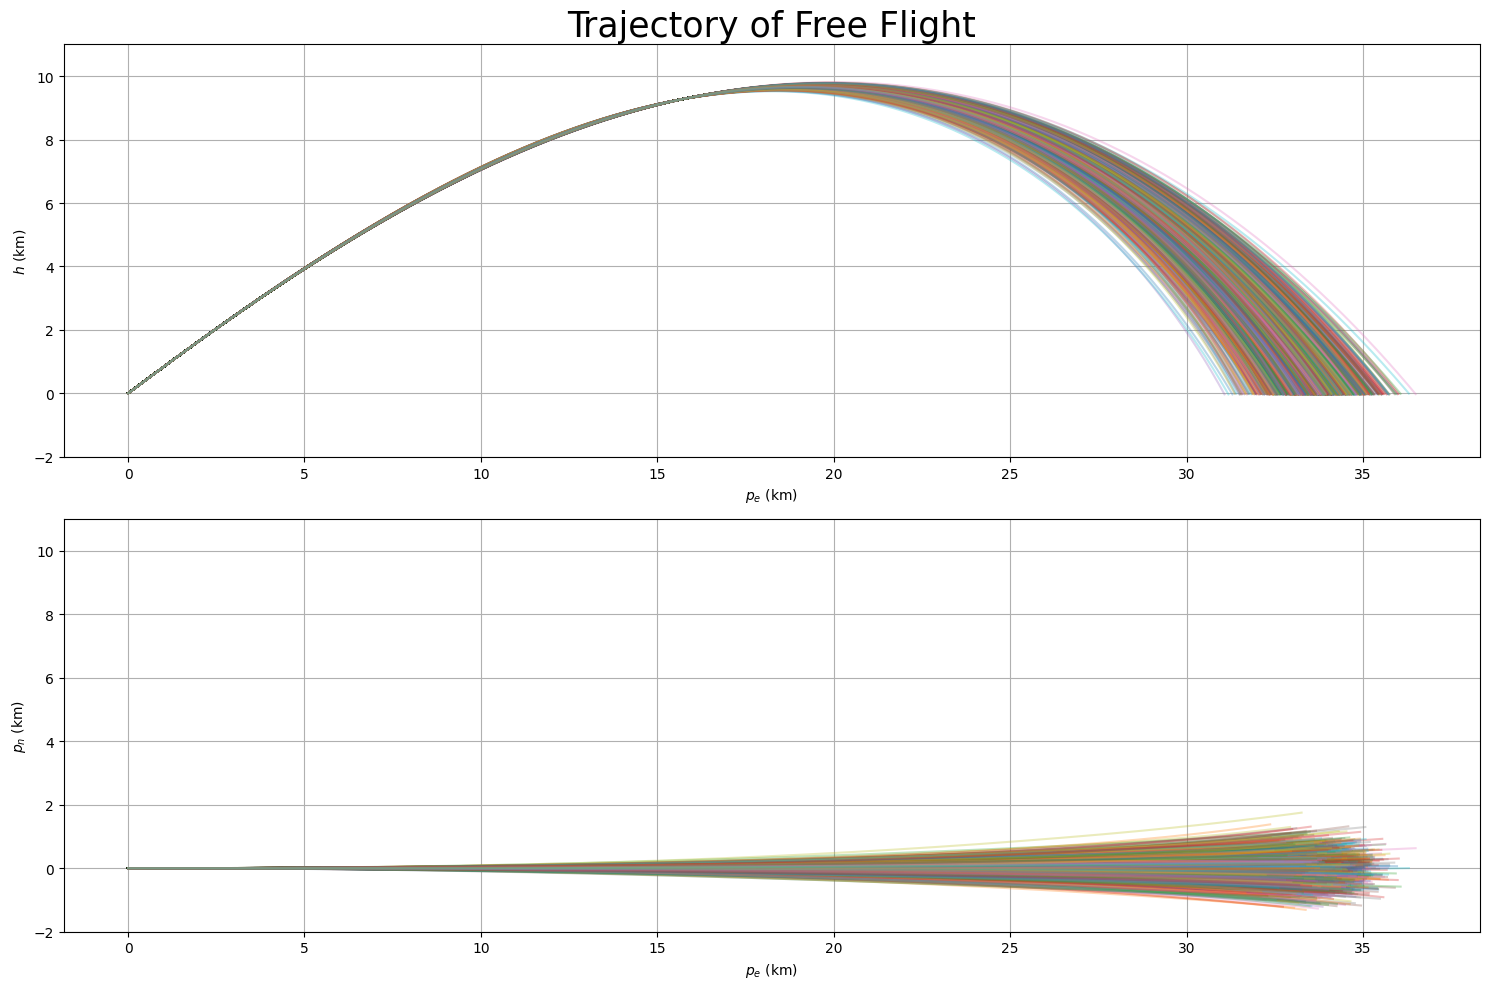

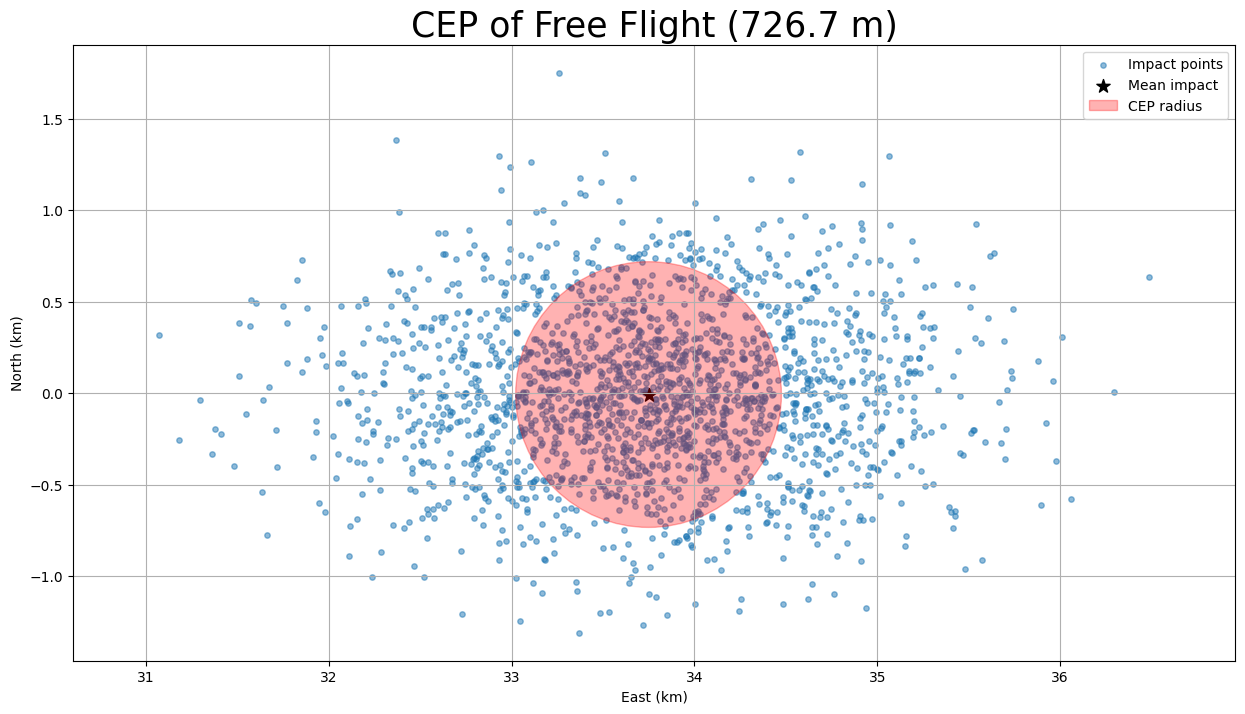

In [140]:
tf = 200.0
dt = 0.1
t = np.arange(0, tf, dt)

init = np.array([
    1000.0,
    40*Deg2Rad,
    90*Deg2Rad,
    0.0, 0.0, 0.0
])

n_mc = 2000

impact_points, traj_list = run_monte_carlo(
    n_mc, init, t, dt
)
trajectory_plot(traj_list, impact_points)


#2. 유도 제어 로켓


In [121]:
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 2.1 시스템 변수
# =========================
m = 40
d = 0.16
S = np.pi*(d/2)**2
g0 = 9.80665
rho0 = 1.225

# drag model params
Cd0 = 0.2
ki  = 5
Cla = 8

Rad2Deg = 180/np.pi
Deg2Rad = 1/Rad2Deg

np.random.seed(0)

def random_wind_init():
    return np.array([
        np.random.normal(0, 5),
        np.random.normal(0, 5),
        0.0
    ])

def random_wind_step(v_w):
    v_w[0] += np.random.normal(0, 1)
    v_w[1] += np.random.normal(0, 1)
    v_w[2] = 0.0
    return v_w


2.1 PN guidance 유도 입력

In [122]:
import numpy as np

def PN_guidance_cmd(t, z, p_target, v_target, N_nav=3.0):
    V, gamma, psi, pn, pe, h = z

    gbar = 9.8
    u_max = 10.0
    t_start = 20.0
    t_cutoff = 1.0

    # Missile position/velocity in NED (Down positive)
    p_m = np.array([pn, pe, -h])
    v_m = np.array([
        V*np.cos(gamma)*np.cos(psi),
        V*np.cos(gamma)*np.sin(psi),
        -V*np.sin(gamma)
    ])

    # Relative vectors (target w.r.t missile)
    p_r = np.array(p_target) - p_m
    v_r = np.array(v_target) - v_m

    pr_norm = np.linalg.norm(p_r) + 1e-12
    vr_norm = np.linalg.norm(v_r) + 1e-12
    tgo = pr_norm / vr_norm

    # 1) initial free-flight
    if t < t_start:
        return np.array([0.0, 0.0])

    # 2) cutoff near target: stop PN, only gravity compensation in z
    if tgo <= t_cutoff:
        return np.array([-gbar*np.cos(gamma), 0.0])

    # LOS rate (lambda_dot)
    lam_dot = np.cross(p_r, v_r) / (pr_norm**2)

    # PN command acceleration in NED
    a_cmd = N_nav * np.cross(v_r, lam_dot)

    # Build trajectory-tangential axes ey, ez
    g_dir = np.array([0.0, 0.0, 1.0])  # NED: Down is +, so gravity direction is +D

    e_y_tilde = np.cross(g_dir, v_m)
    ey_norm = np.linalg.norm(e_y_tilde) + 1e-12
    e_y = e_y_tilde / ey_norm

    e_z_tilde = np.cross(v_m, e_y)
    ez_norm = np.linalg.norm(e_z_tilde) + 1e-12
    e_z = e_z_tilde / ez_norm

    # project + gravity compensation in z
    u_z = (e_z @ a_cmd) - gbar*np.cos(gamma)
    u_y = (e_y @ a_cmd)

    # magnitude limit
    u_norm = np.hypot(u_z, u_y) + 1e-12
    if u_norm > u_max:
        scale = u_max / u_norm
        u_z *= scale
        u_y *= scale

    return np.array([u_z, u_y])


2.2 유도 로켓 운동방정식

In [123]:
def dynamics_guided(t, z, v_w, p_target, v_target):
  V, gamma, psi, pn, pe, h = z

  # 정교한 밀도, 중력
  rho = rho0*np.exp(-h/8500)
  g = g0*(6_378_137/(6_378_137 + h))**2

  # 운동방정식 (kinematics)
  v_n = V*np.cos(gamma)*np.cos(psi)
  v_e = V*np.cos(gamma)*np.sin(psi)
  v_d = -V*np.sin(gamma)
  v_ned = np.array([v_n, v_e, v_d])

  #1. 유도 제어 입력 u=[uz,uy]
  u_z, u_y = PN_guidance_cmd(t, z, p_target, v_target)

  # 상대 속도
  v_rel = v_ned - v_w
  vrel_norm = np.linalg.norm(v_rel) + 1e-12

  #2. 유도 항력 Cd(uz,uy)
  Cd = Cd0 + ki * (4*m**2) * (u_z**2 + u_y**2) / ((rho**2) * (vrel_norm**4) * (S**2) * (Cla**2) + 1e-12)

  # NED 항력
  D_ned = -0.5*rho*S*Cd* vrel_norm * v_rel

  #4. ned -> xyz 변환 행렬
  mat_ned_to_xyz = np.array([
      [np.cos(gamma)*np.cos(psi), np.cos(gamma)*np.sin(psi), -np.sin(gamma)],
      [-np.sin(psi),              np.cos(psi),                            0],
      [np.sin(gamma)*np.cos(psi), np.sin(gamma)*np.sin(psi), np.cos(gamma)]
  ])

  D_xyz = mat_ned_to_xyz @ D_ned

    # modified EOM (문제 식 그대로)

  V_dot = D_xyz[0]/m - g*np.sin(gamma)
  gamma_dot = (-D_xyz[2]/(m*V) - g*np.cos(gamma)/V - u_z/V)
  psi_dot = D_xyz[1]/(m*V) + u_y/V
  pn_dot = v_n
  pe_dot = v_e
  h_dot = -v_d

  return np.array([V_dot, gamma_dot, psi_dot, pn_dot, pe_dot, h_dot])


2.3 수치 적분

In [124]:
def numerical_integ_guided(init, t, dt, p_target, v_target):
    z_hist = [init.copy()]

    v_w = random_wind_init()  # run 시작 시 초기화

    for k in range(len(t)):
        v_w = random_wind_step(v_w)  # 매 step 업데이트

        dz = dynamics_guided(t[k], z_hist[-1], v_w, p_target, v_target)
        z_next = z_hist[-1] + dz * dt
        z_hist.append(z_next)

        if z_next[5] < 0:
            break

    return np.array(z_hist)


2.4 유도로켓 몬테카를로

In [125]:
def run_monte_carlo_guided(n_mc, init, t, dt, p_target, v_target):
    impact_points = []
    traj_list = []

    for i in range(n_mc):
        z_hist = numerical_integ_guided(init.copy(), t, dt, p_target, v_target)

        traj_list.append(z_hist)
        impact_points.append([
            z_hist[-1, 3]/1000,   # North (km)
            z_hist[-1, 4]/1000    # East  (km)
        ])

    return np.array(impact_points), traj_list


2.5 시각화

In [141]:
def guided_trjectory_plotting(traj_list, impact_points, p_target):
    # 1) Trajectory plots
    fig, ax = plt.subplots(2, 1, figsize=(15, 10), dpi=100)

    for z in traj_list:
        ax[0].plot(z[:,4]/1000, z[:,5]/1000, alpha=0.3)  # pe vs h
        ax[1].plot(z[:,4]/1000, z[:,3]/1000, alpha=0.3)  # pe vs pn

    ax[1].scatter([p_target[1]/1000], [p_target[0]/1000],
                  marker='x', s=120, label='Target')
    ax[1].legend()

    ax[0].set_xlabel(r'$p_e$ (km)')
    ax[0].set_ylabel(r'$h$ (km)')
    ax[0].set_ylim(-2, 11)
    ax[0].set_title('Trajectory of Guided Flight', fontsize=25)
    ax[0].grid()

    ax[1].set_xlabel(r'$p_e$ (km)')
    ax[1].set_ylabel(r'$p_n$ (km)')
    ax[1].set_ylim(-2, 11)
    ax[1].grid()

    plt.tight_layout()
    plt.show()

    # 2) CEP plot
    impact_points = np.array(impact_points)

    # 여기서는 impact_points = [north, east] (km) 기준
    north = impact_points[:, 0]
    east  = impact_points[:, 1]

    mean_n = np.mean(north)
    mean_e = np.mean(east)

    dist = np.sqrt(
        (east  - mean_e)**2 +
        (north - mean_n)**2
    )

    cep_radius = np.percentile(dist, 50)   # km
    cep_m = cep_radius * 1000              # m

    plt.figure(figsize=(15, 8), dpi=100)

    # 전체 점
    plt.scatter(east, north, alpha=0.5, s=15, label='Impact points')

    # mean impact
    plt.scatter(mean_e, mean_n,
                color='k', marker='*', s=100, label='Mean impact')

    # CEP 원 (빨간색, 반투명)
    circle = plt.Circle(
        (mean_e, mean_n),
        cep_radius,
        color='red', alpha=0.3, label='CEP radius'
    )
    plt.gca().add_patch(circle)

    # target
    plt.scatter(p_target[1]/1000, p_target[0]/1000,
                marker='+', s=160, c='k', linewidths=2, label='Target')

    plt.xlabel('East (km)')
    plt.ylabel('North (km)')
    plt.axis('equal')
    plt.title(f'CEP of Guided Flight ({cep_m:.1f} m)', fontsize=25)
    plt.legend()
    plt.grid()
    plt.show()


2.6 main

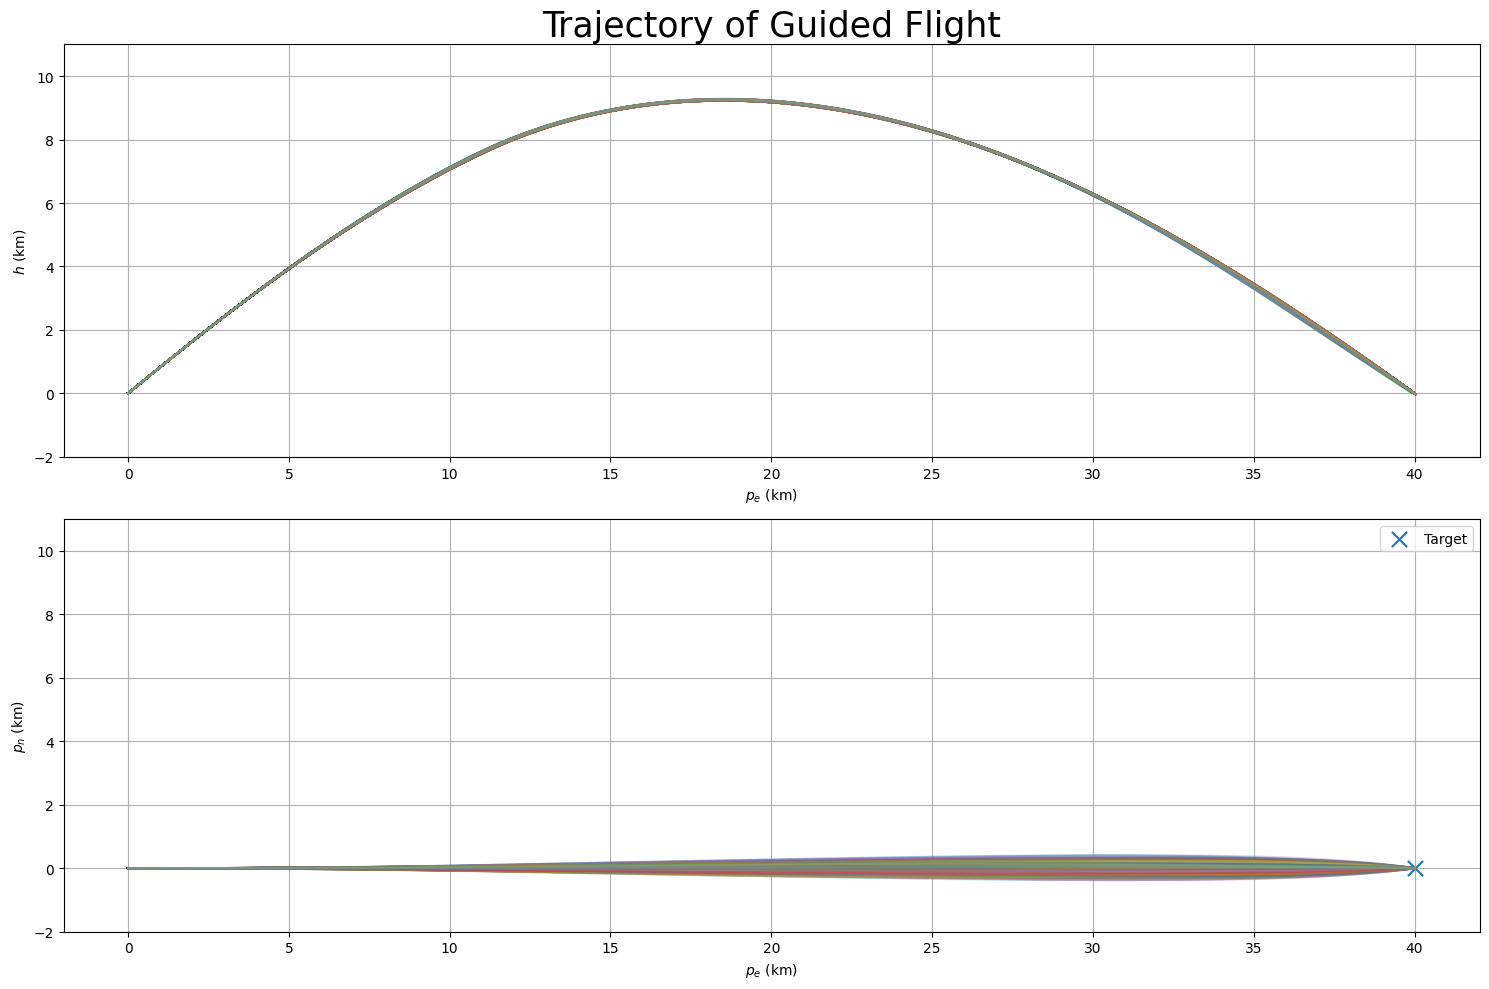

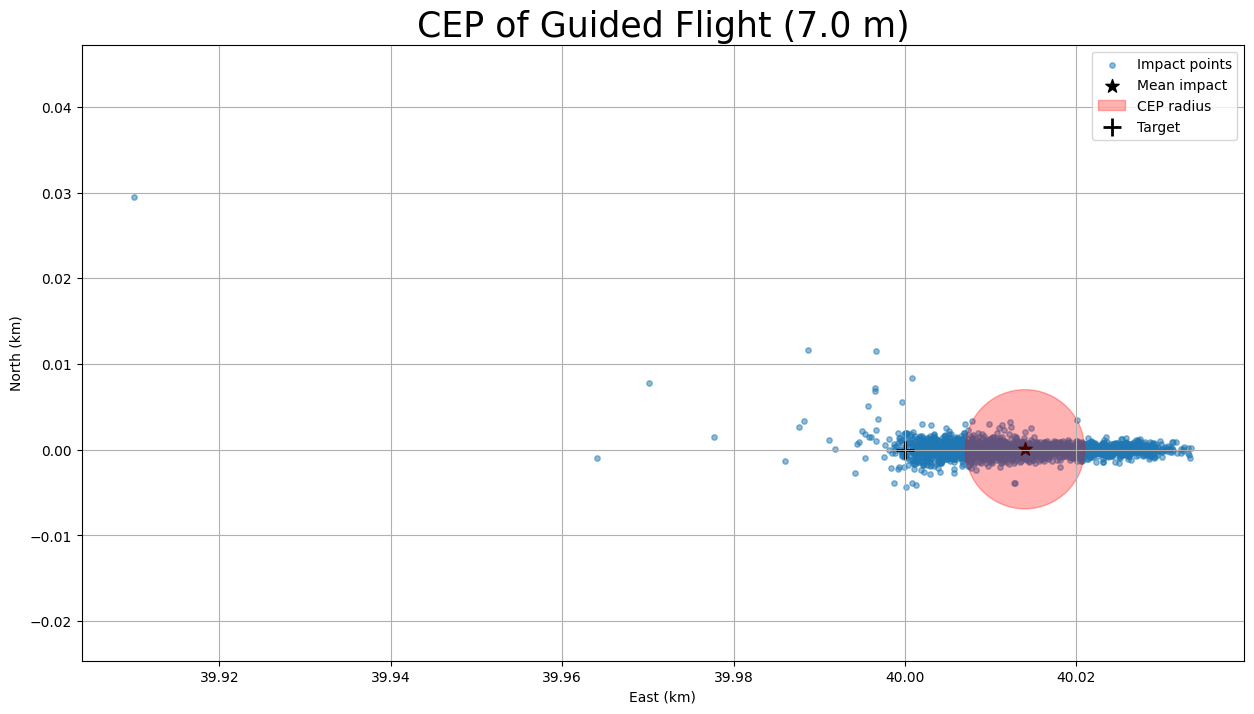

In [142]:
def main():
    tf = 200.0
    dt = 0.1
    t = np.arange(0, tf, dt)

    init = np.array([1000.0, 40*Deg2Rad, 90*Deg2Rad, 0.0, 0.0, 0.0])

    # 목표점 - 북쪽 0km, 동쪽 40km, 고도 0km
    p_target = np.array([0, 40_000.0, 0])  # North=0m, East=34km
    v_target = np.zeros(3)

    n_mc = 2000

    impact_points, traj_list = run_monte_carlo_guided(n_mc, init, t, dt, p_target, v_target)
    guided_trjectory_plotting(traj_list, impact_points, p_target)

if __name__ == "__main__":
    main()
